In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix

In [3]:

#df = pd.read_csv("final_ML_fall25/csv_files/engagement_reddit.csv")

df = pd.read_csv("../../csv_files/engagement_reddit.csv")
TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"



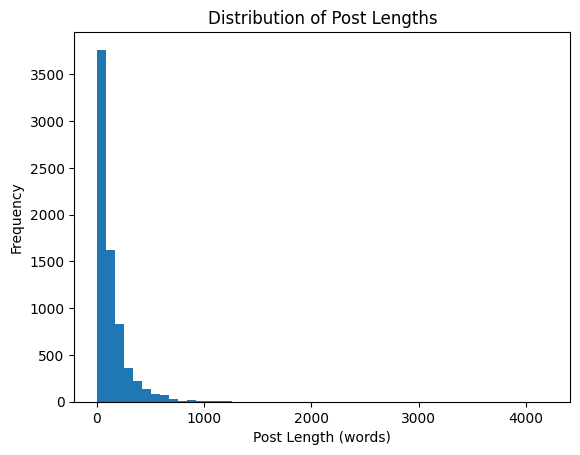

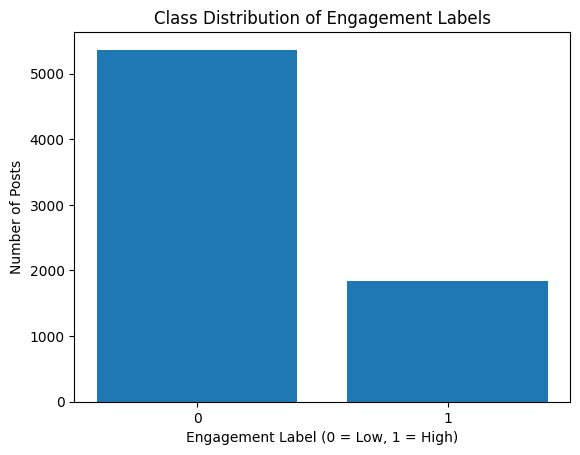

In [4]:
import matplotlib.pyplot as plt

df["post_length"] = df[TEXT_COL].str.split().str.len()

plt.figure()
plt.hist(df["post_length"], bins=50)
plt.xlabel("Post Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Post Lengths")
plt.show()


counts = df[LABEL_COL].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.xlabel("Engagement Label (0 = Low, 1 = High)")
plt.ylabel("Number of Posts")
plt.title("Class Distribution of Engagement Labels")
plt.show()








In [5]:

df_model = df[[TEXT_COL, LABEL_COL]].dropna().copy()


X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].values
y_test  = X_test_df[LABEL_COL].values


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)

X_train = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test  = tfidf.transform(X_test_df[TEXT_COL])


log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",
    random_state=42
)

log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1073
           1       0.67      0.75      0.71       368

    accuracy                           0.84      1441
   macro avg       0.79      0.81      0.80      1441
weighted avg       0.85      0.84      0.84      1441

Confusion Matrix:
[[936 137]
 [ 93 275]]


In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from scipy.sparse import hstack, csr_matrix


df = pd.read_csv("../../csv_files/engagement_reddit.csv")

TEXT_COL = "text_clean"
LABEL_COL = "high_engagement"



df_model = df[[TEXT_COL, LABEL_COL]].dropna().copy()
df_model["post_length"] = df_model[TEXT_COL].str.split().str.len()


X_train_df, X_test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model[LABEL_COL]
)

y_train = X_train_df[LABEL_COL].values
y_test  = X_test_df[LABEL_COL].values


tfidf = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_text = tfidf.fit_transform(X_train_df[TEXT_COL])
X_test_text  = tfidf.transform(X_test_df[TEXT_COL])

X_train_num = csr_matrix(X_train_df[["post_length"]].values)
X_test_num  = csr_matrix(X_test_df[["post_length"]].values)

scaler = StandardScaler(with_mean=False)
X_train_num = scaler.fit_transform(X_train_num)
X_test_num  = scaler.transform(X_test_num)

X_train = hstack([X_train_text, X_train_num])
X_test  = hstack([X_test_text, X_test_num])

param_grid = {
    "C": [0.01, 0.1, 0.5, 1, 5, 10]
}

grid = GridSearchCV(
    LogisticRegression(
        max_iter=1000,
        solver="liblinear",
        class_weight="balanced",
        random_state=42
    ),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


y_pred = grid.best_estimator_.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1073
           1       0.81      0.79      0.80       368

    accuracy                           0.90      1441
   macro avg       0.87      0.86      0.87      1441
weighted avg       0.90      0.90      0.90      1441

Confusion Matrix:
[[1006   67]
 [  78  290]]


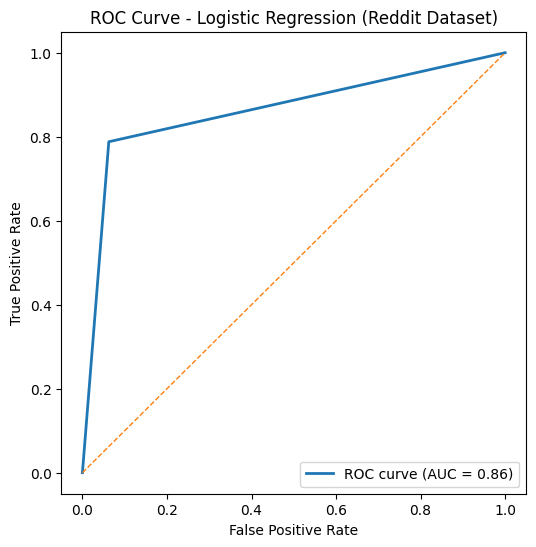

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# Get decision scores (NOT probabilities)
y_scores = grid.best_estimator_.predict(X_test)

# ROC curve + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Reddit Dataset)')
plt.legend(loc='lower right')
plt.show()